# Custom Datasets

In [95]:
import torch
import requests
import zipfile
from pathlib import Path

In [96]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [97]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"Directory {image_path} already exists.")
else:
    print(f"Creating directory {image_path}...")
    image_path.mkdir(parents=True)

zip_file = "pizza_steak_sushi.zip"

# Check if file already exists
if (data_path / zip_file).is_file():
    print(f"File {zip_file} already exists.")
else:
    # Download data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading pizza_steak_sushi.zip...")
        url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        response = requests.get(url)
        f.write(response.content)
        print("pizza_steak_sushi.zip downloaded!")
    
# Check if pizza_steak_sushi dir is empty
if len(list(image_path.glob("*"))) == 0:
    print(f"Extracting {zip_file}...")
    with zipfile.ZipFile(data_path / zip_file, "r") as zip_ref:
        zip_ref.extractall(image_path)
    print(f"{zip_file} extracted!")

Directory data\pizza_steak_sushi already exists.
File pizza_steak_sushi.zip already exists.


In [98]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [99]:
# Visualizing images
import random
from PIL import Image

random.seed(42)

# get all image paths
image_path_list = list(image_path.glob("**/*.jpg"))

# randomly choose image
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.name

# view image
img = Image.open(random_image_path)
print(f"random image path: {random_image_path}")
print(f"random image class: {image_class}")
print(f"random image size: {img.size}")
print(f"random image height: {img.height}")
print(f"random image width: {img.width}")

random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
random image class: sushi
random image size: (512, 408)
random image height: 408
random image width: 512


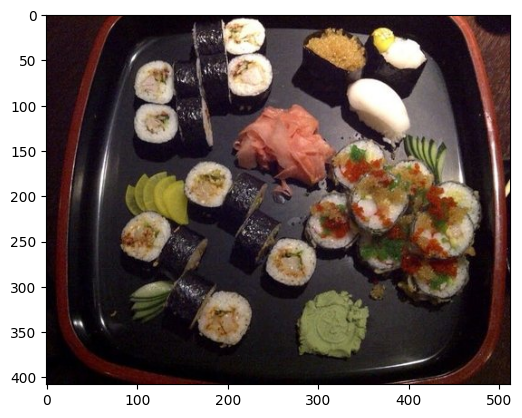

In [100]:
# Visualizing image with matplotlib
import matplotlib.pyplot as plt
import numpy as np
image_array = np.array(img)
plt.imshow(image_array)

In [101]:
# Transforming images to tensors
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [102]:
# Write a transform for images
data_transform = transforms.Compose([
    # resize to 64x64
    transforms.Resize((64, 64), ),
    # flip the image ramdomly on horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # convert the image to a tensor with pixels in range [0, 1]
    transforms.ToTensor()
])

data_transform(img).shape


torch.Size([3, 64, 64])

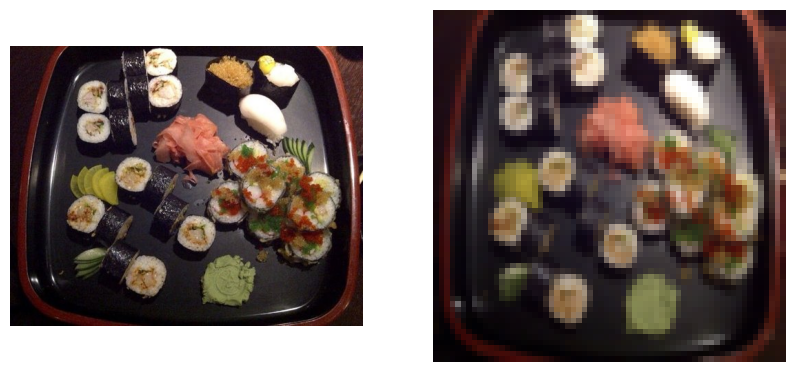

In [103]:
# Visualizing transformed images
def show_transformed_image(transform, image):
    # show image and transformed image side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    # show image
    ax1.imshow(image)
    # show transformed image
    ax2.imshow(transform(image).permute(1, 2, 0))
    ax1.axis("off")
    ax2.axis("off")


show_transformed_image(data_transform, img)

### Option 1. Loading image data using ImageFolder dataloader

In [104]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=image_path / "train", transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=image_path / "test", transform=data_transform, target_transform=None)

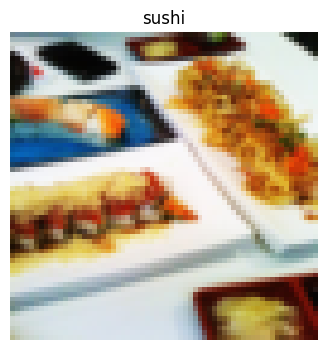

In [105]:
# Visualizing a random image with its label from train_data
random.seed(42)
random_index = random.randint(0, len(train_data))
sample_image, sample_label = train_data[random_index]
plt.figure(figsize=(4, 4))
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis("off")
_ = plt.title(train_data.classes[sample_label])

In [106]:
# Create data loaders
import os
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
len(train_loader), len(train_data)

(8, 225)

In [107]:
img, label = next(iter(train_loader))
img.shape, label


(torch.Size([32, 3, 64, 64]),
 tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0,
         0, 0, 2, 0, 0, 0, 0, 1]))

## Option 2. Loading image data using a custom Dataset

In [108]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [109]:
# function to get class names from a folder
train_dir = image_path / "train"
test_dir = image_path / "test"
class_names_found = sorted([entry.name for entry in os.scandir(train_dir) if entry.is_dir()])
class_names_found

['pizza', 'steak', 'sushi']

In [110]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Returns all the class names found in a directory.
    """
    # Find the class folders (all folders inside `directory`).
    directory = pathlib.Path(directory)
    classes = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
    if not classes:
        raise Exception(f"Couldn't find any class folders in {directory}.")
    classes.sort()
    # Assign a numerical value to each class.
    class_to_idx = {cls_name: index for index, cls_name in enumerate(classes)}
    return classes, class_to_idx

class_names, class_to_idx = find_classes(train_dir)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Now we're ready to build our own custom `Dataset`.

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`. 

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom `Dataset`.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data). 
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [111]:
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform: transforms.Compose = None):
        """
        Args:
            target_dir: path to a directory where images are stored.
            transform: transforms to apply on each image.
        """
        # get all image paths
        self.target_dir = pathlib.Path(target_dir)
        self.paths = list(self.target_dir.glob("*/*.jpg"))
        
        # Setup transforms
        self.transform = transform
        
        # Find classes.
        self.classes, self.class_to_idx = find_classes(self.target_dir)
        
    # Create a function to load an Image
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # Override __len__
    def __len__(self) -> int:
        return len(self.paths)
    
    # Override __getitem__
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns:
            tuple (image, target) where target is index of the target class.
        """
        image = self.load_image(index)
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[image_path.parent.name]
        return image, label
    

In [112]:
# Create a transform
train_transform = transforms.Compose([
    # resize to 64x64
    transforms.Resize((64, 64), ),
    # flip the image ramdomly on horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # convert the image to a tensor with pixels in range [0, 1]
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64), ),
    transforms.ToTensor()
])

In [113]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=train_transform)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transform)

len(train_data_custom), len(train_data)

(225, 225)

In [114]:
train_data_custom.classes, train_data.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [115]:
# Create the dataloaders
train_loader_custom = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader_custom = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())


### Other forms of augmentation

In [116]:
# Trivial Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224), ),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224), ),
    transforms.ToTensor()
])

In [117]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

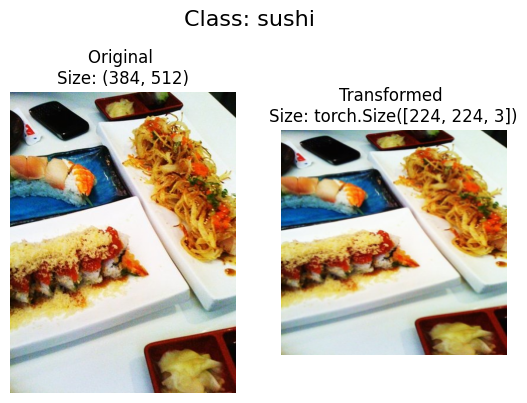

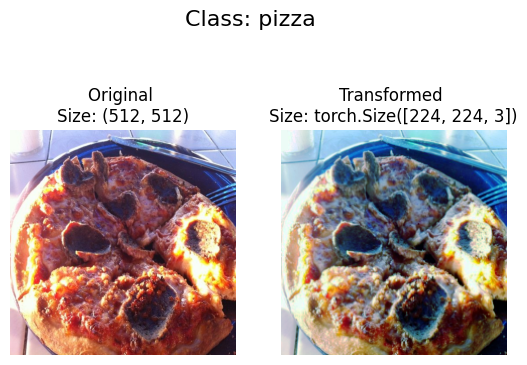

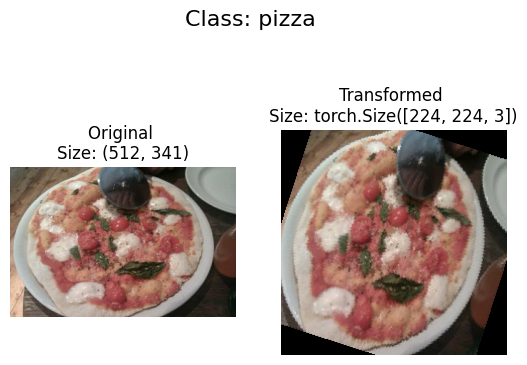

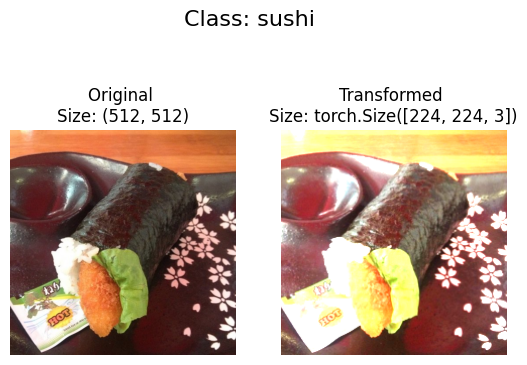

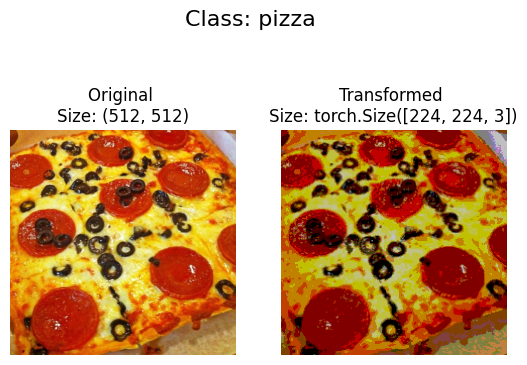

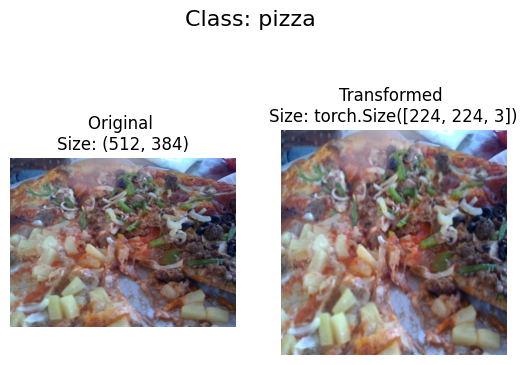

In [118]:
image_paths = list(train_dir.glob("**/*.jpg"))
plot_transformed_images(image_paths, train_transform, n=6, seed=42)

### Model 0: TinyVGG Without data augmentation

In [119]:
# Simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64), ),
    transforms.ToTensor()
])

In [120]:
# Create datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Simple transform
simple_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.ToTensor()
])

train_data_simple = ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = ImageFolder(root=test_dir, transform=simple_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader_simple = DataLoader(train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [121]:
# Create TinyVGG Model
import torch.nn as nn

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_width: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*int(image_width/4)*int(image_width/4),
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [122]:
# Create a train and test loop function
def train_step( model: nn.Module,
                dataloader: DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        
        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Calculate accuracy
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += torch.sum(y_pred_class == y).item() / len(y)
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test_step(  model: nn.Module,
                dataloader: DataLoader,
                loss_fn: nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          
          # Forward pass
          y_pred = model(X)
          
          # Calculate loss
          loss = loss_fn(y_pred, y)
          test_loss += loss.item()
          
          # Calculate accuracy
          y_pred_class = torch.argmax(y_pred, dim=1)
          acc = torch.sum(y_pred_class == y).item() / len(y)
          test_acc += acc

        #   print("y_pred_class")
        #   print(y_pred_class)
        #   print("y")
        #   print(y)
        #   print("acc")
        #   print(acc)
          
      test_loss /= len(dataloader)
      test_acc /= len(dataloader)
    return test_loss, test_acc
        
        

In [123]:
from tqdm.auto import tqdm
# Create a train() function to combine train_step() and test_step()
def train(  model: nn.Module,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            loss_fn: nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int):
    # Create an empty result dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through traing and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        # Testing step
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Print results
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")
    
    return results
        

0it [00:00, ?it/s]

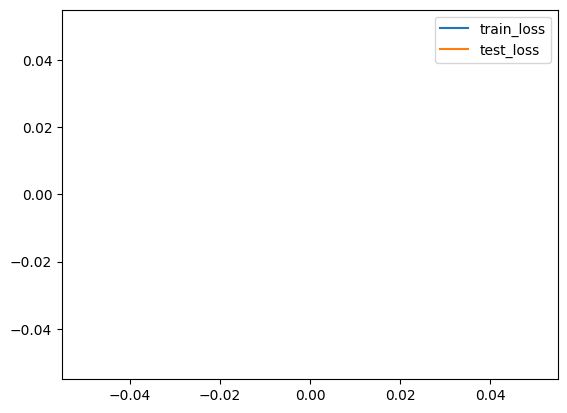

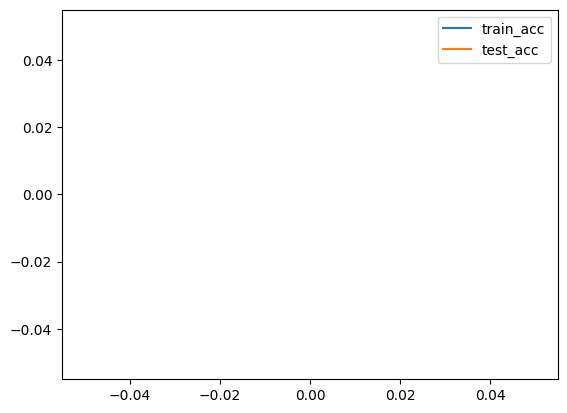

In [124]:
import torchinfo

torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 0

model_0 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(train_data.classes),
                  image_width=64).to(device)
torchinfo.summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

results_0 = train(model_0, train_loader_simple, test_loader_simple, loss_fn, optimizer, EPOCHS)

# Plot the loss
plt.plot(results_0["train_loss"], label="train_loss")
plt.plot(results_0["test_loss"], label="test_loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(results_0["train_acc"], label="train_acc")
plt.plot(results_0["test_acc"], label="test_acc")
plt.legend()
plt.show()



### Model 0: TinyVGG With trivial data augmentation

In [125]:
# Trivial augmentation transform
train_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.ToTensor()
])

train_data = ImageFolder(root=train_dir, transform=train_transform)
test_data = ImageFolder(root=test_dir, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

0it [00:00, ?it/s]

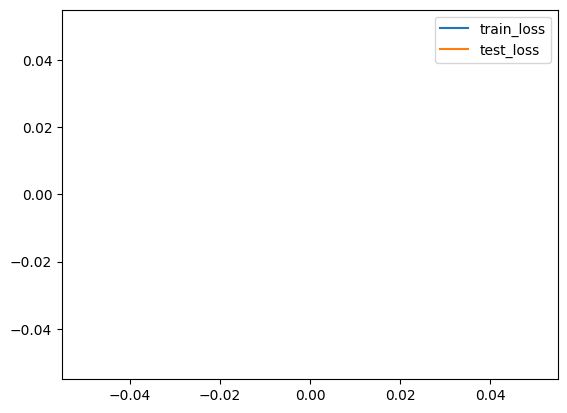

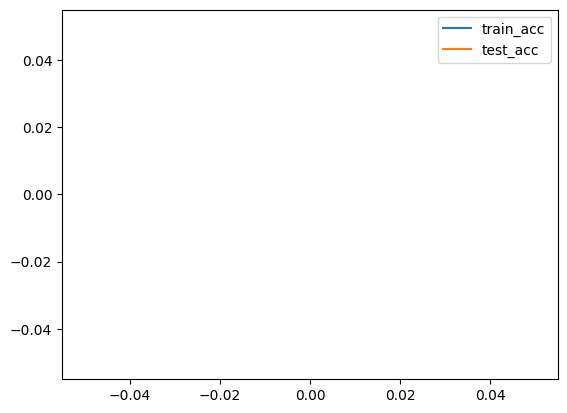

In [126]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 0

model_0 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(train_data.classes),
                  image_width=64).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

results_0 = train(model_0, train_loader, test_loader, loss_fn, optimizer, EPOCHS)

# Plot the loss
plt.plot(results_0["train_loss"], label="train_loss")
plt.plot(results_0["test_loss"], label="test_loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(results_0["train_acc"], label="train_acc")
plt.plot(results_0["test_acc"], label="test_acc")
plt.legend()
plt.show()

### Model 2: TinyVGG With 128 pixel images

In [127]:
# Trivial augmentation transform
train_transform = transforms.Compose([
  transforms.Resize((128, 128), ),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((128, 128), ),
  transforms.ToTensor()
])

train_data = ImageFolder(root=train_dir, transform=train_transform)
test_data = ImageFolder(root=test_dir, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

0it [00:00, ?it/s]

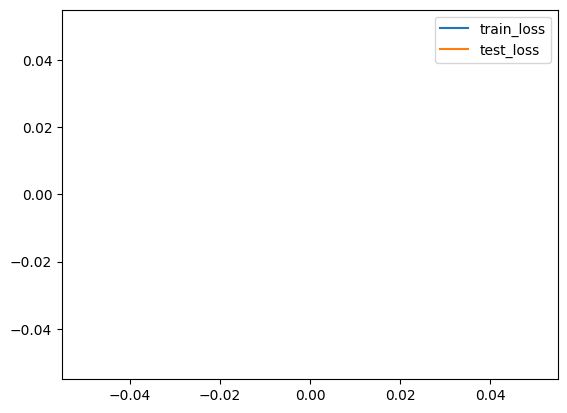

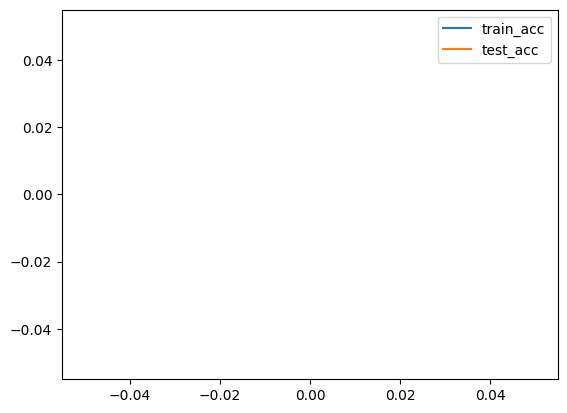

In [128]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 0

model_2 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(train_data.classes),
                  image_width=128).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

results_2 = train(model_2, train_loader, test_loader, loss_fn, optimizer, EPOCHS)

# Plot the loss
plt.plot(results_2["train_loss"], label="train_loss")
plt.plot(results_2["test_loss"], label="test_loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(results_2["train_acc"], label="train_acc")
plt.plot(results_2["test_acc"], label="test_acc")
plt.legend()
plt.show()

### Model 3: TinyVGG with 3 conv stages

In [132]:
class TinyVGGV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_width: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*int(image_width/4)*int(image_width/4),
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [133]:
# Trivial augmentation transform
train_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.ToTensor()
])

train_data = ImageFolder(root=train_dir, transform=train_transform)
test_data = ImageFolder(root=test_dir, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [134]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 30

model_3 = TinyVGGV2(input_shape=3,
                  hidden_units=64,
                  output_shape=len(train_data.classes),
                  image_width=64).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

results_3 = train(model_3, train_loader, test_loader, loss_fn, optimizer, EPOCHS)

# Plot the loss
plt.plot(results_3["train_loss"], label="train_loss")
plt.plot(results_3["test_loss"], label="test_loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(results_3["train_acc"], label="train_acc")
plt.plot(results_3["test_acc"], label="test_acc")
plt.legend()
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30, Train Loss: 1.1050, Train Acc: 0.40, Test Loss: 1.1146, Test Acc: 0.20
Epoch: 2/30, Train Loss: 1.1127, Train Acc: 0.29, Test Loss: 1.1159, Test Acc: 0.20
Epoch: 3/30, Train Loss: 1.0983, Train Acc: 0.29, Test Loss: 1.1028, Test Acc: 0.20
Epoch: 4/30, Train Loss: 1.0999, Train Acc: 0.29, Test Loss: 1.1114, Test Acc: 0.26
Epoch: 5/30, Train Loss: 1.0947, Train Acc: 0.43, Test Loss: 1.1107, Test Acc: 0.26
Epoch: 6/30, Train Loss: 1.0750, Train Acc: 0.43, Test Loss: 1.1560, Test Acc: 0.27
Epoch: 7/30, Train Loss: 1.0728, Train Acc: 0.49, Test Loss: 1.0755, Test Acc: 0.33
Epoch: 8/30, Train Loss: 1.0995, Train Acc: 0.40, Test Loss: 0.9206, Test Acc: 0.59
Epoch: 9/30, Train Loss: 1.0253, Train Acc: 0.54, Test Loss: 1.0303, Test Acc: 0.49
Epoch: 10/30, Train Loss: 1.0520, Train Acc: 0.50, Test Loss: 0.9539, Test Acc: 0.60
Epoch: 11/30, Train Loss: 1.0731, Train Acc: 0.39, Test Loss: 1.0322, Test Acc: 0.58
Epoch: 12/30, Train Loss: 1.0431, Train Acc: 0.39, Test Loss: 0.9724, Test

KeyboardInterrupt: 

### Model 4: TinyVGG with kernel=5 in 1st conv stage 

In [ ]:
class TinyVGGV3(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_width: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=5, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=2), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*int(image_width/4)*int(image_width/4),
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
# Trivial augmentation transform
train_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((64, 64), ),
  transforms.ToTensor()
])

train_data = ImageFolder(root=train_dir, transform=train_transform)
test_data = ImageFolder(root=test_dir, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30, Train Loss: 1.1080, Train Acc: 0.30, Test Loss: 1.0414, Test Acc: 0.57
Epoch: 2/30, Train Loss: 1.1030, Train Acc: 0.29, Test Loss: 1.0328, Test Acc: 0.58
Epoch: 3/30, Train Loss: 1.1213, Train Acc: 0.36, Test Loss: 1.1016, Test Acc: 0.31
Epoch: 4/30, Train Loss: 1.0826, Train Acc: 0.35, Test Loss: 1.0099, Test Acc: 0.58
Epoch: 5/30, Train Loss: 1.0681, Train Acc: 0.43, Test Loss: 1.0448, Test Acc: 0.37
Epoch: 6/30, Train Loss: 0.9884, Train Acc: 0.61, Test Loss: 1.0741, Test Acc: 0.35
Epoch: 7/30, Train Loss: 0.9925, Train Acc: 0.40, Test Loss: 0.9999, Test Acc: 0.43
Epoch: 8/30, Train Loss: 1.0582, Train Acc: 0.38, Test Loss: 1.0310, Test Acc: 0.49
Epoch: 9/30, Train Loss: 1.0513, Train Acc: 0.46, Test Loss: 1.0159, Test Acc: 0.42
Epoch: 10/30, Train Loss: 0.9451, Train Acc: 0.58, Test Loss: 1.0365, Test Acc: 0.33
Epoch: 11/30, Train Loss: 1.0627, Train Acc: 0.41, Test Loss: 1.0543, Test Acc: 0.37
Epoch: 12/30, Train Loss: 0.9564, Train Acc: 0.54, Test Loss: 1.0598, Test

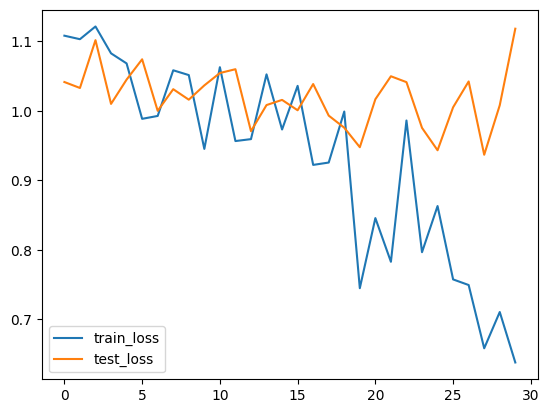

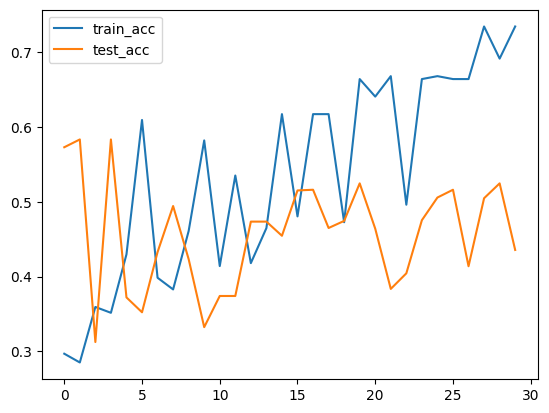

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 30

model_4 = TinyVGGV3(input_shape=3,
                  hidden_units=64,
                  output_shape=len(train_data.classes),
                  image_width=64).to(device)

# torchinfo.summary(model_4, input_size=(BATCH_SIZE, 3, 64, 64))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

results_4 = train(model_4, train_loader, test_loader, loss_fn, optimizer, EPOCHS)

# Plot the loss
plt.plot(results_4["train_loss"], label="train_loss")
plt.plot(results_4["test_loss"], label="test_loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(results_4["train_acc"], label="train_acc")
plt.plot(results_4["test_acc"], label="test_acc")
plt.legend()
plt.show()